# 04 Korrelation & Zusammenhangsanalyse
--------------------------------------------------------------------

In diesem Notebook analysieren wir die Zusammenhänge zwischen verschiedenen Variablen im Taxi-Datensatz. Wir untersuchen:
- Korrelationen zwischen numerischen Variablen
- Zusammenhänge zwischen Fahrtstrecke, Dauer, Kosten und Trinkgeld

## 1. Daten laden und vorbereiten

In [8]:
# Importieren der benötigten Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import random
import csv
import os

# Einstellungen für bessere Visualisierung
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Größere Plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [9]:
df_clean = pd.read_csv('../data/Taxi_final_1M_clean.csv')

# Zeitvariablen berechnen
df_clean['pickup_datetime'] = pd.to_datetime(df_clean['tpep_pickup_datetime'])
df_clean['pickup_hour'] = df_clean['pickup_datetime'].dt.hour
df_clean['pickup_day_of_week'] = df_clean['pickup_datetime'].dt.dayofweek

print(f"Bereinigter Datensatz geladen: {df_clean.shape[0]:,} Zeilen, {df_clean.shape[1]} Spalten")
print(f"Fehlende Werte: {df_clean.isnull().sum().sum()}")
df_clean.head()

Bereinigter Datensatz geladen: 967,493 Zeilen, 20 Spalten
Fehlende Werte: 0


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,average_speed,pickup_datetime,pickup_hour,pickup_day_of_week
0,2023-02-06 18:31:28,2023-02-06 18:41:28,1.0,2.8,162,113,1,11.4,2.5,2.00,0.0,1.0,19.90,2.5,0.0,10.0,17.0,2023-02-06 18:31:28,18,0
1,2023-01-24 12:53:51,2023-01-24 13:06:09,5.0,2.3,142,48,2,12.1,0.0,0.00,0.0,1.0,16.10,2.5,0.0,12.3,11.2,2023-01-24 12:53:51,12,1
2,2023-02-04 22:58:49,2023-02-04 23:03:11,2.0,1.1,107,107,1,5.8,3.5,1.20,0.0,1.0,12.00,2.5,0.0,4.4,15.5,2023-02-04 22:58:49,22,5
3,2023-02-02 16:39:15,2023-02-02 16:50:39,1.0,2.9,234,249,1,12.1,2.5,3.72,0.0,1.0,22.32,2.5,0.0,11.4,15.5,2023-02-02 16:39:15,16,3
4,2023-02-15 21:08:32,2023-02-15 21:14:12,1.0,1.2,230,48,1,7.2,1.0,2.44,0.0,1.0,14.64,2.5,0.0,5.7,13.1,2023-02-15 21:08:32,21,2


## 2. Korrelationsmatrix - Überblick über alle Zusammenhänge

Wir berechnen die Korrelation zwischen allen numerischen Variablen. Der Korrelationskoeffizient misst die Beziehung zwischen zwei Variablen und liegt zwischen -1 und +1:
- +1: Perfekte positive Korrelation
- 0: Keine lineare Korrelation
- -1: Perfekte negative Korrelation

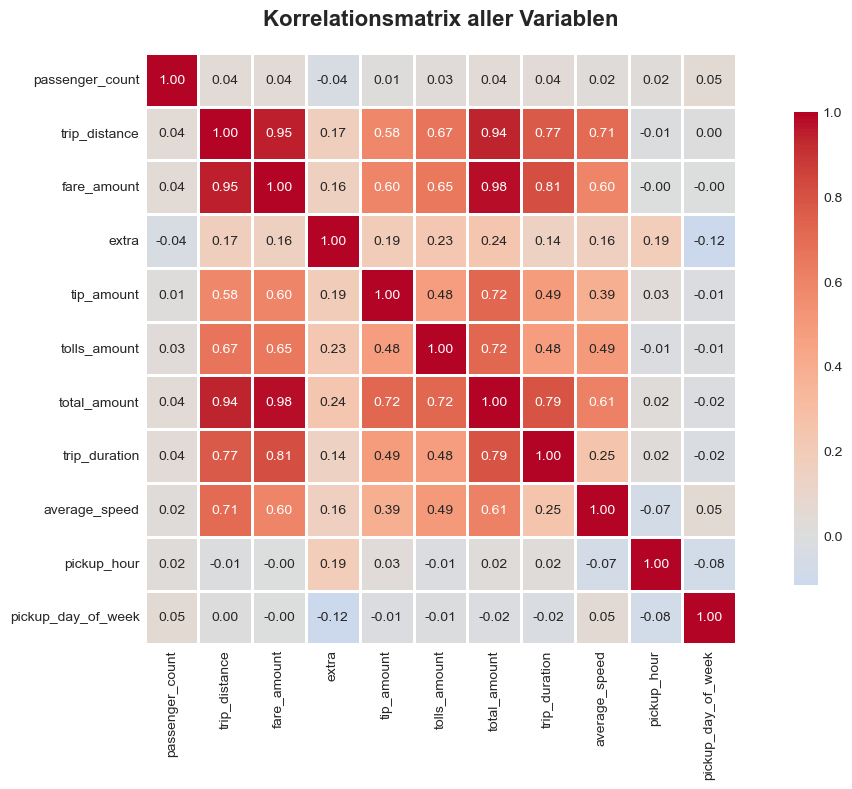

In [10]:
# Auswahl der numerischen Variablen
numerical_cols = ['passenger_count', 'trip_distance', 'fare_amount', 
                  'extra', 'tip_amount', 'tolls_amount', 
                  'total_amount', 'trip_duration', 'average_speed',
                  'pickup_hour', 'pickup_day_of_week']

# Korrelationsmatrix
correlation_matrix = df_clean[numerical_cols].corr()

# Visualisierung der Korrelationsmatrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Korrelationsmatrix aller Variablen', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [11]:
# Die stärksten Korrelationen identifizieren (Diagonale auslassen)
# Korrelationsmatrix zu DataFrame 
corr_pairs = correlation_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1]  # Diagonale entfernen

# Sortieren nach 
strong_correlations = corr_pairs.abs().sort_values(ascending=False).drop_duplicates()

print("Die stärksten Korrelationen:")
for idx, value in strong_correlations.head(10).items():
    print(f"{idx[0]:15s} <-> {idx[1]:15s}: {corr_pairs[idx]:7.3f}")

Die stärksten Korrelationen:
total_amount    <-> fare_amount    :   0.979
fare_amount     <-> trip_distance  :   0.950
trip_distance   <-> total_amount   :   0.941
trip_duration   <-> fare_amount    :   0.813
total_amount    <-> trip_duration  :   0.795
trip_duration   <-> trip_distance  :   0.766
total_amount    <-> tolls_amount   :   0.724
total_amount    <-> tip_amount     :   0.719
trip_distance   <-> average_speed  :   0.711
trip_distance   <-> tolls_amount   :   0.669


Es hat zahlreiche starke Korrelationen in unserem Datensatz. Eigentlich sind alle sehr logisch, wie z.B. dass der Fahrpreis mit der Fahrdistanz oder der Fahrzeit korreliert. Zunächst werden wir 3 dieser Korrelationen visualisieren. 

## 3. Fahrstrecke und Fahrpreis

Eine der wichtigsten Zusammenhänge ist die Beziehung zwischen der Fahrstrecke (`trip_distance`) und dem Fahrpreis (`fare_amount`). Das soll 1 zu 1 korrelieren.

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


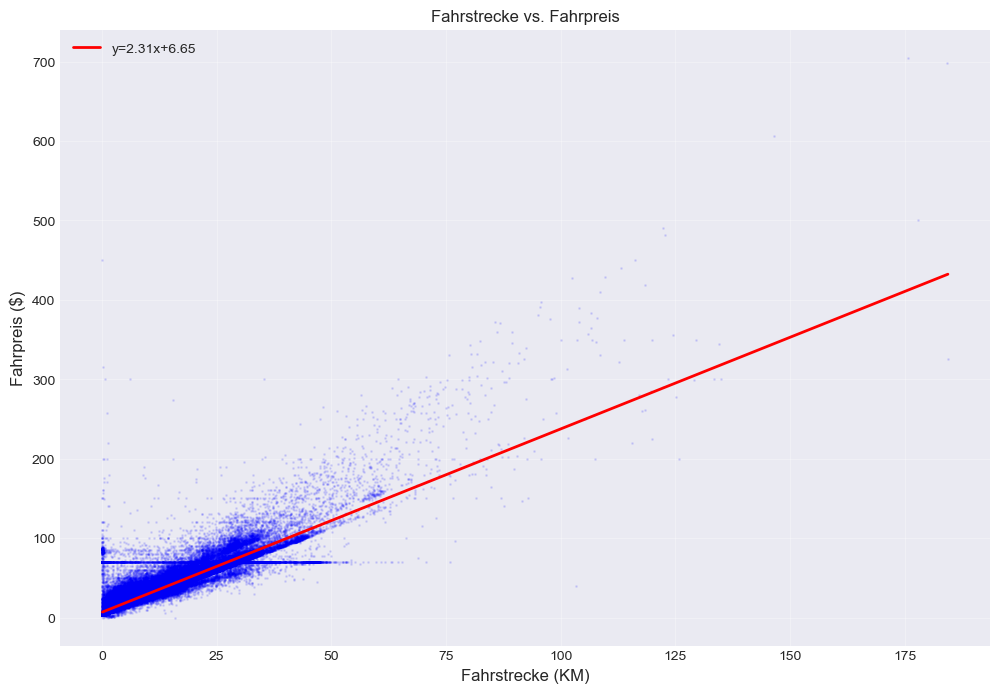

In [12]:
# Scatterplot: Fahrstrecke vs. Fahrpreis
plt.scatter(df_clean['trip_distance'], df_clean['fare_amount'], 
                alpha=0.1, s=1, c='blue')

# Regressionslinie hinzufügen
z = np.polyfit(df_clean['trip_distance'], df_clean['fare_amount'], 1)
p = np.poly1d(z)
plt.plot(df_clean['trip_distance'].sort_values(), 
             p(df_clean['trip_distance'].sort_values()), 
             "r-", linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')

plt.xlabel('Fahrstrecke (KM)', fontsize=12)
plt.ylabel('Fahrpreis ($)', fontsize=12)
plt.title('Fahrstrecke vs. Fahrpreis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Die Horizontale Linie ist vermutlich eine Basisgebühr bei Pickups vom JFK Airport (bei 70$). Deshalb lassen wir es drin.

## 4. Zusammenhang: Fahrstrecke und Fahrdauer

Fahrstrecke und Fahrdauer sollen logischerweise auch korrelieren, abhängig von der Durchschnittsgeschwindigkeit.

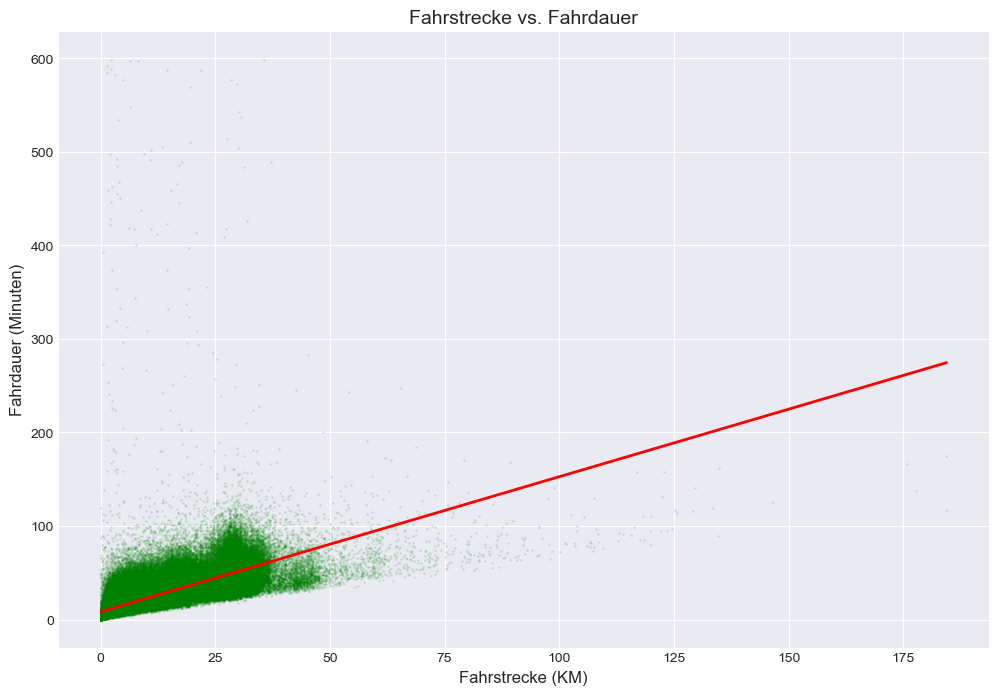


Durchschnittliche Geschwindigkeit aller Fahrten: 18.33 km/h


In [13]:
# Scatterplot: Fahrstrecke vs. Fahrdauer
plt.scatter(df_clean['trip_distance'], df_clean['trip_duration'], 
                alpha=0.1, s=1, c='green')

z = np.polyfit(df_clean['trip_distance'], df_clean['trip_duration'], 1)
p = np.poly1d(z)

plt.plot(df_clean['trip_distance'].sort_values(), 
             p(df_clean['trip_distance'].sort_values()), 
             "r-", linewidth=2)
plt.xlabel('Fahrstrecke (KM)', fontsize=12)
plt.ylabel('Fahrdauer (Minuten)', fontsize=12)
plt.title('Fahrstrecke vs. Fahrdauer', fontsize=14)
plt.show()


# Durchschnittliche Geschwindigkeit
avg_speed_overall = df_clean['average_speed'].mean()
print(f"\nDurchschnittliche Geschwindigkeit aller Fahrten: {avg_speed_overall:.2f} km/h")


In diesem Scatterplot ist erkennbar dass die Fahrstrecke und Fahrdauer positiv linear korrelieren, mit vereinzelte Fahrten die kurze Distanzen über eine sehr lange Zeit gemacht haben (z.b. bei längeren Wartezeiten). Durch die Datenbereinigung gibt es kein Ausreisser bei sehr hohen Fahrstrecken bei sehr kurzer Zeit, da das natürlich nicht möglich wäre. 

## 5. Zusammenhang: Trinkgeld und Fahrpreis

Ein interessanter Zusammenhang ist die Beziehung zwischen dem Trinkgeld (`tip_amount`) und dem Fahrpreis (`fare_amount`). Wir erwarten ein höheres Trinkgeld bei höheren Fahrpreis, da es Konvention ist prozentual Trinkgeld zu geben.

Wir analysieren nur Credit Card Zahlungen, da bei Cash Trinkgeld nicht richtig erfasst wird.

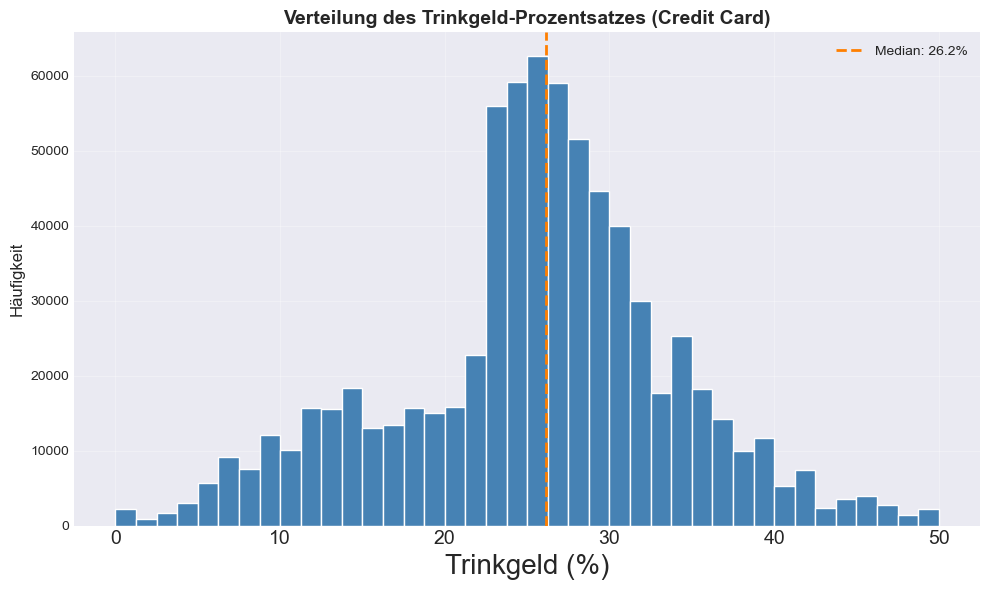

---Trinkgeld Statistiken (nur Credit Card)---
Durchschnittlicher Prozentsatz Trinkgeld: 27.20%
Median Prozentsatz Trinkgeld: 26.17%
Credit Card Fahrten mit Trinkgeld: 736,151
Anteil an allen Credit Card Fahrten: 95.6%


In [14]:
# Trinkgeld-Prozentsatz berechnen
df_clean['tip_percentage'] = (df_clean['tip_amount'] / df_clean['fare_amount']) * 100

# Nur Credit Card Zahlungen mit Trinkgeld (Payment Type 1)
df_with_tip = df_clean[(df_clean['payment_type'] == 1) & (df_clean['tip_amount'] > 0)].copy()
median_tip_perfentage = df_with_tip["tip_percentage"].median()

# Trinkgeld-Prozentsatz Verteilung Histrogramm
plt.figure(figsize=(10, 6))
df_with_tip[df_with_tip['tip_percentage'] <= 50]['tip_percentage'].hist(
    bins=40, color='#4682B4', edgecolor='white')
plt.xlabel('Trinkgeld (%)', fontsize=20)
plt.ylabel('Häufigkeit', fontsize=12)
plt.title('Verteilung des Trinkgeld-Prozentsatzes (Credit Card)', fontsize=14, fontweight='bold')
plt.axvline(median_tip_perfentage, color='#FF7F00', 
            linestyle='--', linewidth=2, label=f'Median: {median_tip_perfentage:.1f}%')
plt.xticks(fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("---Trinkgeld Statistiken (nur Credit Card)---")
print(f"Durchschnittlicher Prozentsatz Trinkgeld: {df_with_tip['tip_percentage'].mean():.2f}%")
print(f"Median Prozentsatz Trinkgeld: {df_with_tip['tip_percentage'].median():.2f}%")
print(f"Credit Card Fahrten mit Trinkgeld: {len(df_with_tip):,}")
print(f"Anteil an allen Credit Card Fahrten: {len(df_with_tip)/len(df_clean[df_clean['payment_type']==1])*100:.1f}%")

In diesem Plot ist zu sehen dass bei Kartenzahlungen der Trinkgeld Prozentsatz ungefähr normalverteilt ist. Es ist in der USA üblich zwischen 20-30% Trinkgeld zu geben, was hier auch deutlich zu erkennen ist. 